# Dataiku exercise : income classification

## libraries downloads
*Spacy* is useful for NLP, I use it here to assign the feature names to the columns of my datasets.

In [5]:
!pip install spacy
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 62.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=bc08f2b0ce00c68913bbc5b9a1b000e436db1bcbd1cb53d0ad9407f98d08a118
  Stored in directory: /tmp/pip-ephem-wheel-cache-pi_hn1x4/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


## libraries import

In [1]:
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

nlp = spacy.load('en_core_web_md')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## functions 

In [0]:
#extract information from the metadata file using Spacy
def column_builder(path):
  metadata = open(path)
  nb_line = 0
  column_list = []
  for line in metadata:
    nb_line +=1
    if nb_line >= 24 and nb_line <= 68:
      line_doc = nlp(line)
      for token in line_doc:
        if token.is_upper:
          column_list.append(str(token))

  del_feat = ['AGI','FEDTAX', 'PEARNVAL', 'PTOTVAL', 'TAXINC']
  final_columns = [ele for ele in column_list if ele not in del_feat]
  final_columns.append('YEAR')
  final_columns.append('INC')
  return final_columns


#computing NA %
def NA_percentages(df):
  percentages = []
  tot = df.isnull().sum()
  n = len(df)
  percentages.append((tot/n)*100)
  return percentages

#function useful to normalize the data
def normalization(training_df, testing_df):
  list_numeric = ['AAGE','ADTIND','ADTOCC','AHRSPAY','CAPGAIN', 'CAPLOSS', 'DIVVAL','NOEMP','SEOTR','WKSWORK']

  for column in list_numeric:
    min_elt = min(min(training_df[column]), min(testing_df[column]))
    max_elt = max(max(training_df[column]), max(testing_df[column]))

    training_df[column] = (training_df[column]-min_elt)/(max_elt-min_elt)
    testing_df[column] = (testing_df[column]-min_elt)/(max_elt-min_elt)
  return training_df, testing_df


# 1-hot encoding function on the combination of training and testing 
# useful if some values are missing in the training dataset
def concat_deconcat(data_train,data_test, column_keep, column_dummies):
  len_column_keep = len(column_keep)
  len_column_dummies = len(column_dummies)
  len_data_train = len(data_train)
  len_data_test = len(data_test)
  data_concat=pd.concat([data_train,data_test],sort=False)
  data = data_concat.loc[:,column_keep]
  data = pd.get_dummies(data,columns = column_dummies)
  modified_train = data.iloc[:len_data_train]
  modified_test = data.iloc[len_data_train:]
  return (modified_train, modified_test)


## datasets import & modification

**IMPORTANT NOTE : YOU WILL NEED TO CHANGE THE FILES PATH AS I WORKED IN COLAB**

In [3]:

training_df = pd.read_csv('/content/drive/My Drive/EMA/Stage/dataiku/census_income_learn.csv', header = None)
testing_df = pd.read_csv('/content/drive/My Drive/EMA/Stage/dataiku/census_income_test.csv', header = None)

#changing the columns names
training_df.columns = column_builder('/content/drive/My Drive/EMA/Stage/dataiku/census_income_metadata.txt')
testing_df.columns = column_builder('/content/drive/My Drive/EMA/Stage/dataiku/census_income_metadata.txt')

#we need to drop the 'instance_weight' feature because it shouldn't be used for classification 
training_df = training_df.drop(columns='MARSUPWT')
testing_df = testing_df.drop(columns='MARSUPWT')

#modify the '?' values into NaNs
training_df = training_df.replace(to_replace=' ?',value=np.NaN)
testing_df = testing_df.replace(to_replace=' ?',value=np.NaN)


#checking if it worked
training_df.head()
testing_df.head()

# normalization of the numerical features
mod_training_df, mod_testing_df = normalization(training_df, testing_df)

#separating the features and the label
features_training_df = mod_training_df.drop(columns='INC')
features_testing_df = mod_testing_df.drop(columns='INC')
training_labels_df = mod_training_df['INC']
testing_labels_df = mod_testing_df['INC']

testing_df.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,GRINREG,GRINST,HHDFMX,HHDREL,MIGMTR1,MIGMTR3,MIGMTR4,MIGSAME,MIGSUN,NOEMP,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR,INC
0,0.422222,Private,0.117647,0.782609,1st 2nd 3rd or 4th grade,0.0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,White,Mexican (Mexicano),Female,Not in universe,Not in universe,Full-time schedules,0.0,0.0,0.000,Joint one under 65 & one 65+,Not in universe,Not in universe,Spouse of householder,Spouse of householder,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0.666667,Not in universe,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0.0,Not in universe,2,0.230769,95,- 50000.
1,0.488889,Self-employed-not incorporated,0.725490,0.260870,Associates degree-occup /vocational,0.0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,White,All other,Female,Not in universe,Not in universe,PT for econ reasons usually PT,0.0,0.0,0.025,Joint both under 65,Not in universe,Not in universe,Spouse of householder,Spouse of householder,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0.166667,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0.0,Not in universe,2,0.500000,95,- 50000.
2,0.022222,Not in universe,0.000000,0.000000,Children,0.0,Not in universe,Never married,Not in universe or children,Not in universe,White,Mexican-American,Male,Not in universe,Not in universe,Children or Armed Forces,0.0,0.0,0.000,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0.000000,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0.0,Not in universe,0,0.000000,95,- 50000.
3,0.388889,Private,0.568627,0.065217,High school graduate,0.0,Not in universe,Divorced,Transportation,Executive admin and managerial,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0.0,0.0,0.000,Head of household,Not in universe,Not in universe,Householder,Householder,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0.833333,Not in universe,United-States,United-States,United-States,Native- Born in the United States,1.0,Not in universe,2,1.000000,94,- 50000.
4,0.544444,Private,0.078431,0.739130,High school graduate,0.0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0.0,0.0,0.000,Single,Not in universe,Not in universe,Secondary individual,Nonrelative of householder,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0.666667,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0.0,Not in universe,2,0.961538,95,- 50000.


## describing the variables

### % of missing values

In [0]:
NA_percentages(features_training_df),NA_percentages(features_testing_df)

([AAGE         0.000000
  ACLSWKR      0.000000
  ADTIND       0.000000
  ADTOCC       0.000000
  AHGA         0.000000
  AHRSPAY      0.000000
  AHSCOL       0.000000
  AMARITL      0.000000
  AMJIND       0.000000
  AMJOCC       0.000000
  ARACE        0.000000
  AREORGN      0.000000
  ASEX         0.000000
  AUNMEM       0.000000
  AUNTYPE      0.000000
  AWKSTAT      0.000000
  CAPGAIN      0.000000
  CAPLOSS      0.000000
  DIVVAL       0.000000
  FILESTAT     0.000000
  GRINREG      0.000000
  GRINST       0.354846
  HHDFMX       0.000000
  HHDREL       0.000000
  MIGMTR1     49.967172
  MIGMTR3     49.967172
  MIGMTR4     49.967172
  MIGSAME      0.000000
  MIGSUN      49.967172
  NOEMP        0.000000
  PARENT       0.000000
  PEFNTVTY     3.364524
  PEMNTVTY     3.066814
  PENATVTY     1.700556
  PRCITSHP     0.000000
  SEOTR        0.000000
  VETQVA       0.000000
  VETYN        0.000000
  WKSWORK      0.000000
  YEAR         0.000000
  dtype: float64], [AAGE         0.00000

As some features have about **50%** of missing data, I will probably drop these columns for the classification.

### numerical data

The `.describe()`method allows us to have information on the numerical columns. Specifically, we can look at the mean and standard deviation of each column, but also the max value.
I decided to pass the argument `include='all'` because it helps getting the number of unique values in the categorical columns.

>
As an example, I believe I won't be using the categorical features where the top value is `NaN`, as I said previously. eg : `MIGSUN`.
- Obviously, the mean and the standard deviation here are the normalized values.

In [0]:
features_training_df.describe(include='all')

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,GRINREG,GRINST,HHDFMX,HHDREL,MIGMTR1,MIGMTR3,MIGMTR4,MIGSAME,MIGSUN,NOEMP,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR
count,199523.000000,199523,199523.000000,199523.000000,199523,199523.000000,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523.000000,199523.000000,199523.000000,199523,199523,198815,199523,199523,99827,99827,99827,199523,99827,199523.000000,199523,192810,193404,196130,199523,199523.000000,199523,199523.000000,199523.000000,199523.000000
unique,NaN,9,NaN,NaN,17,NaN,3,7,24,15,5,10,2,3,6,8,NaN,NaN,NaN,6,6,50,38,8,9,8,9,3,3,NaN,5,42,42,42,5,NaN,3,NaN,NaN,NaN
top,NaN,Not in universe,NaN,NaN,High school graduate,NaN,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,NaN,NaN,NaN,Nonfiler,Not in universe,Not in universe,Householder,Householder,Nonmover,Nonmover,Nonmover,Not in universe under 1 year old,Not in universe,NaN,Not in universe,United-States,United-States,United-States,Native- Born in the United States,NaN,Not in universe,NaN,NaN,NaN
freq,NaN,100245,NaN,NaN,48407,NaN,186943,86485,100684,100684,167365,171907,103984,180459,193453,123769,NaN,NaN,NaN,75094,183750,183750,53248,75475,82538,82538,82538,101212,84054,NaN,144232,159163,160479,176989,176992,NaN,197539,NaN,NaN,NaN
mean,0.383269,NaN,0.301026,0.245795,NaN,0.005543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004347,0.008098,0.001975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.326030,NaN,NaN,NaN,NaN,NaN,0.087719,NaN,1.514833,0.445671,94.499672
std,0.247899,NaN,0.354257,0.314222,NaN,0.027492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.046976,0.059005,0.019842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.394188,NaN,NaN,NaN,NaN,NaN,0.276847,NaN,0.851473,0.469452,0.500001
min,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,94.000000
25%,0.166667,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,0.000000,94.000000
50%,0.366667,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,0.153846,94.000000
75%,0.555556,NaN,0.647059,0.565217,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,1.000000,95.000000


Let's have a look at the data distribution visually :

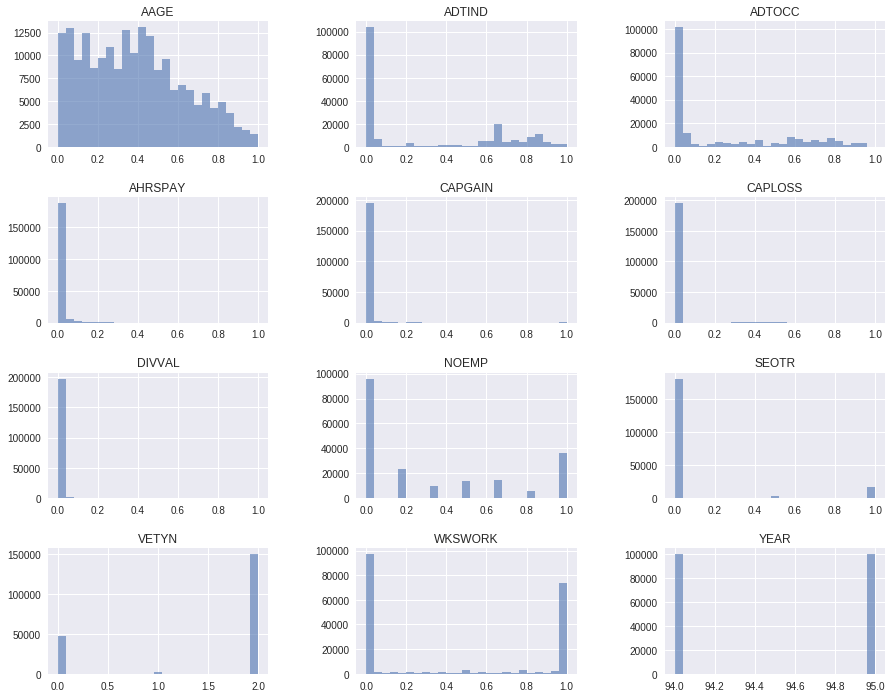

In [0]:
plt.style.use(u'seaborn')
hist = features_training_df.hist(bins=25, figsize=(15,12), alpha=0.6)
plt.subplots_adjust(hspace=0.4, wspace=0.4)


To truly know if a feature is useful or not, we plot a heatmap of the correlation matrix between features. 


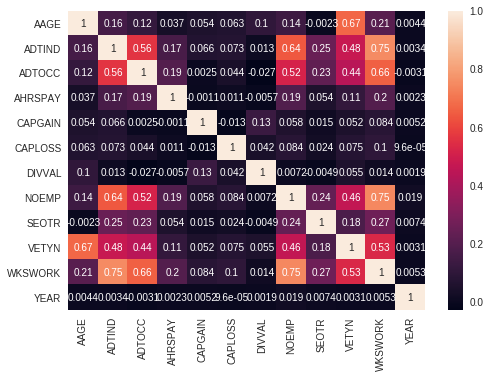

In [0]:
sns.heatmap(features_training_df.corr(), annot=True)

As we can see on the correlation heatmap, some feature don't seem to have much correlation with other features, they will be useless in our classification.
We will drop : 
- YEAR
- DIVVAL
- CAPLOSS
- CAPGAIN

### categorical data

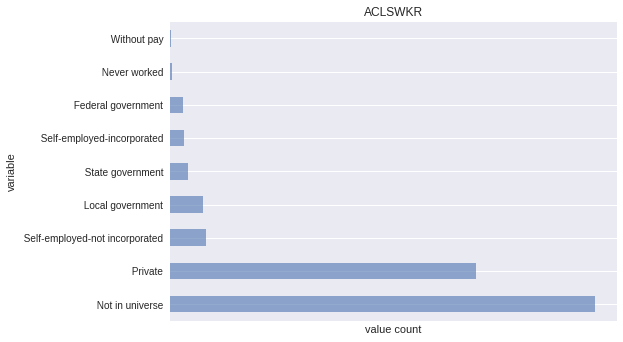

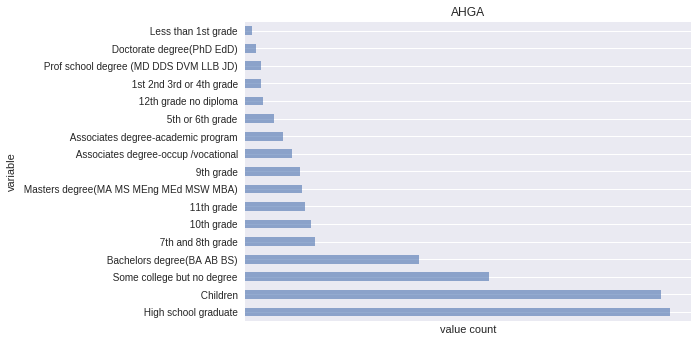

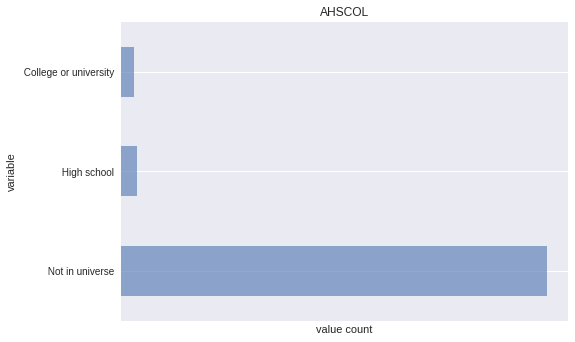

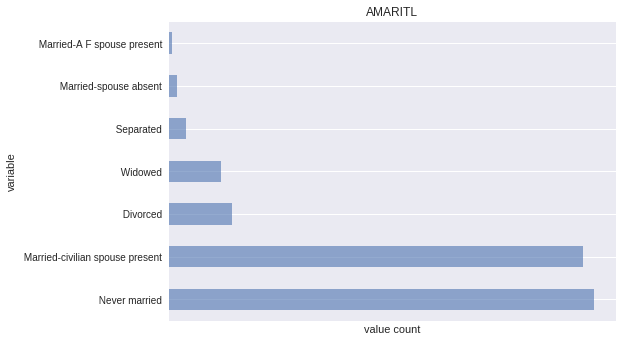

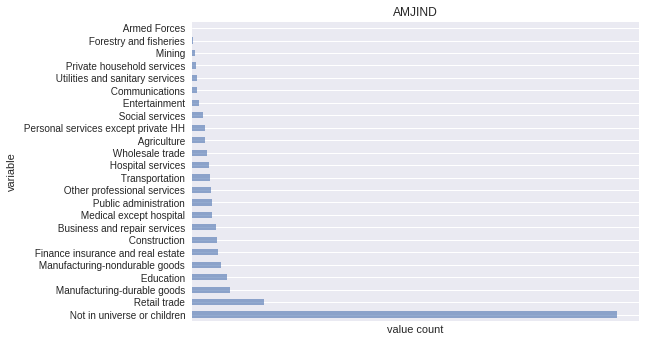

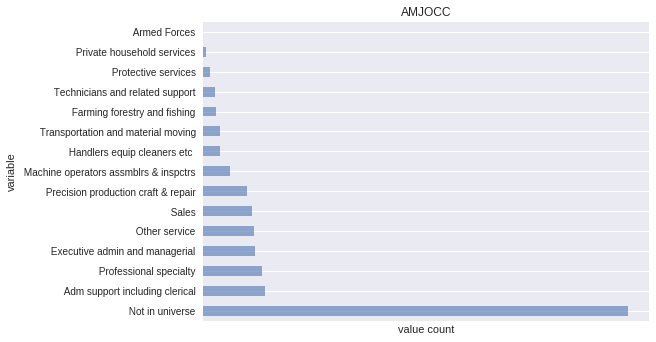

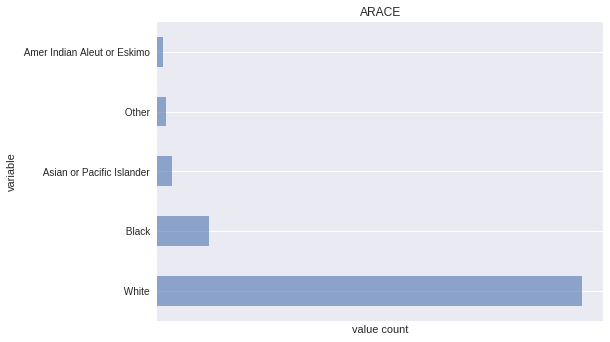

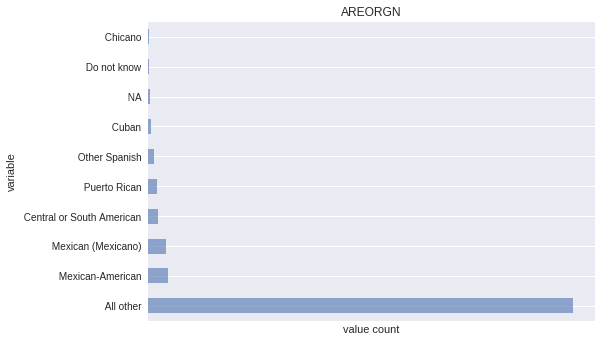

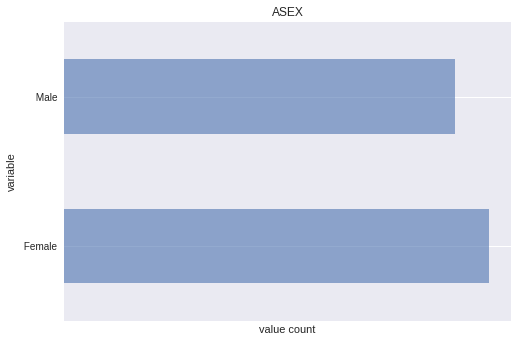

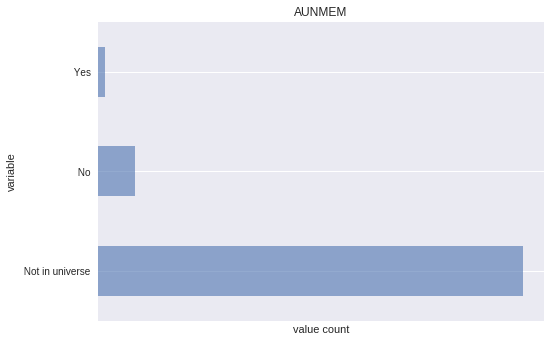

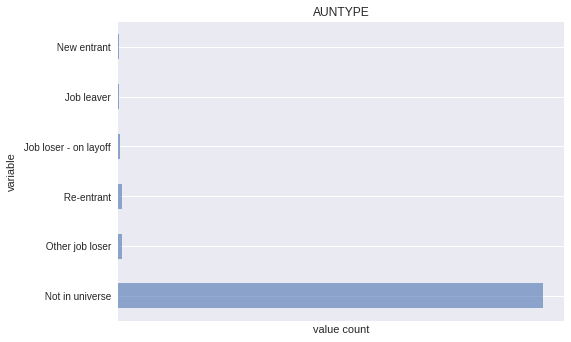

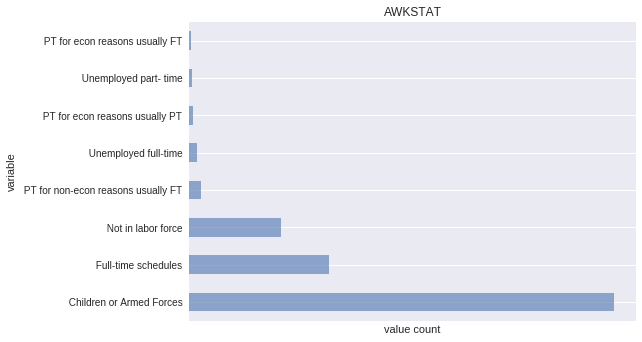

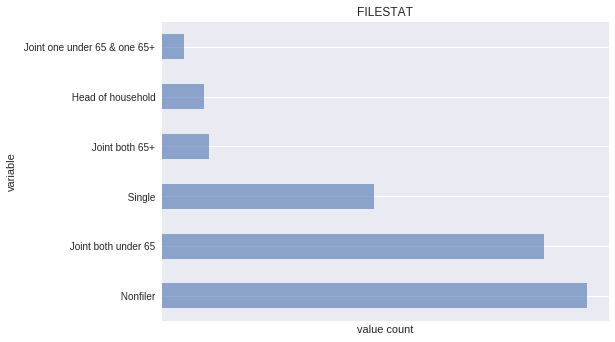

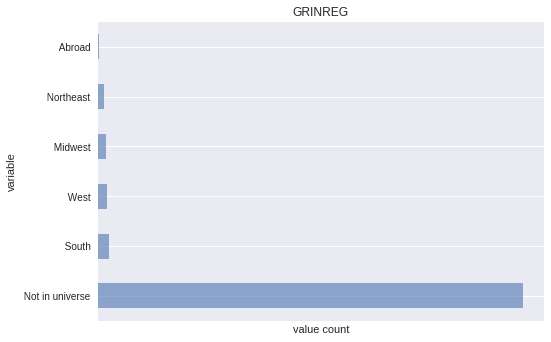

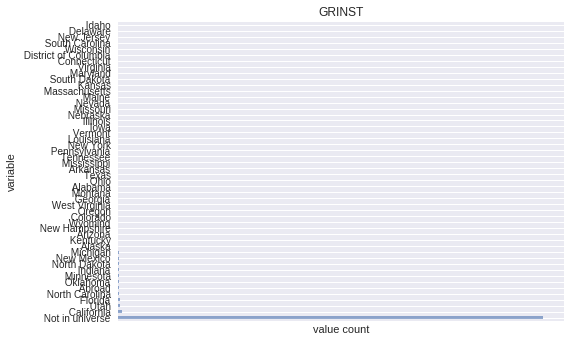

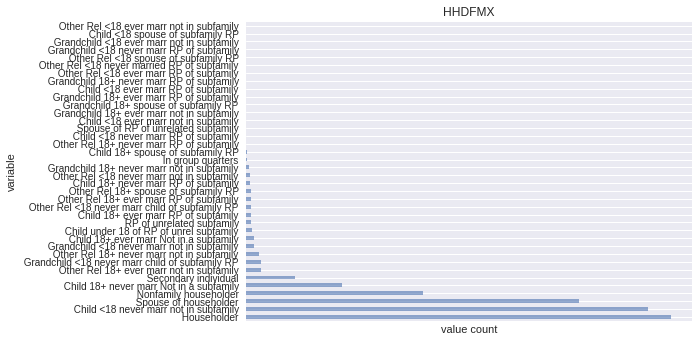

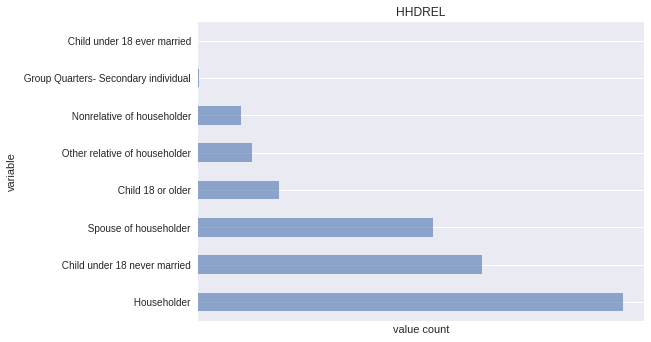

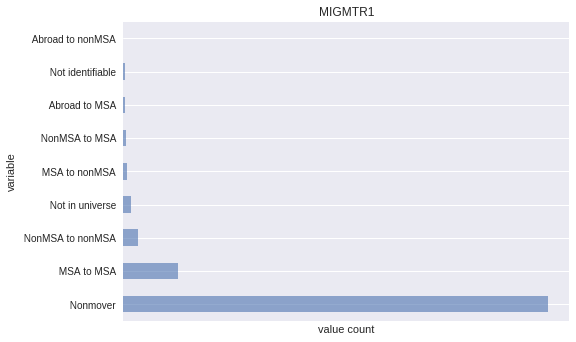

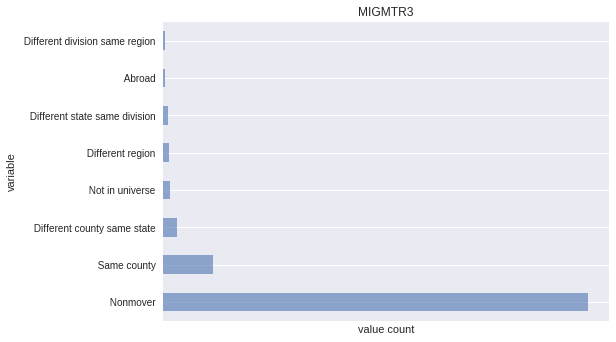

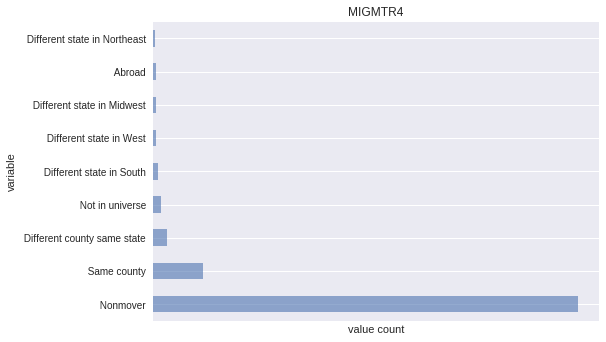

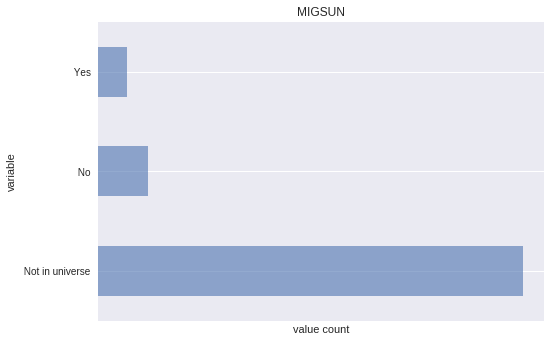

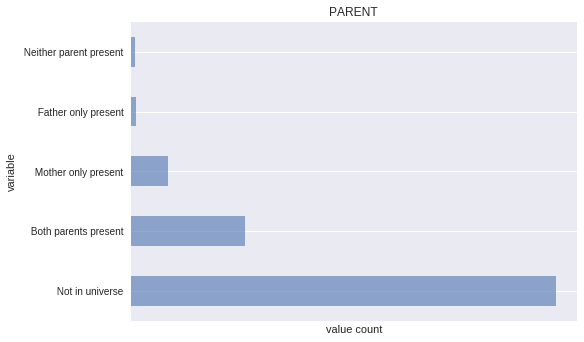

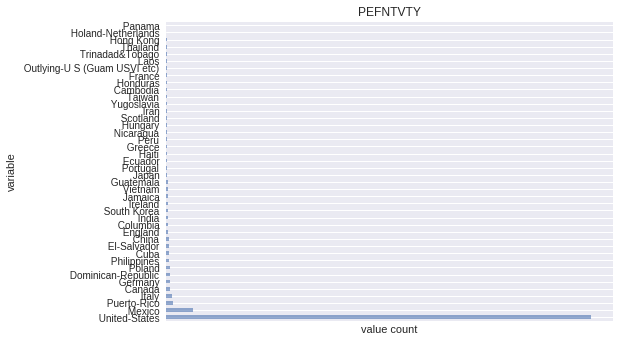

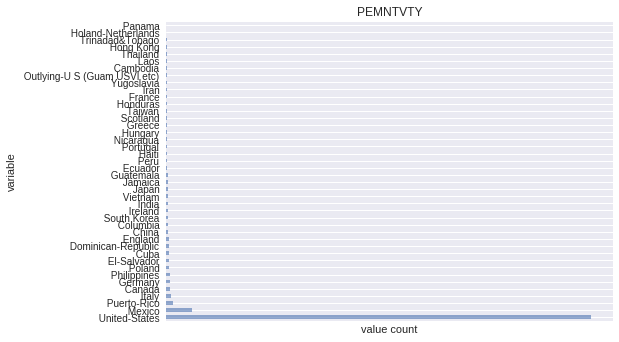

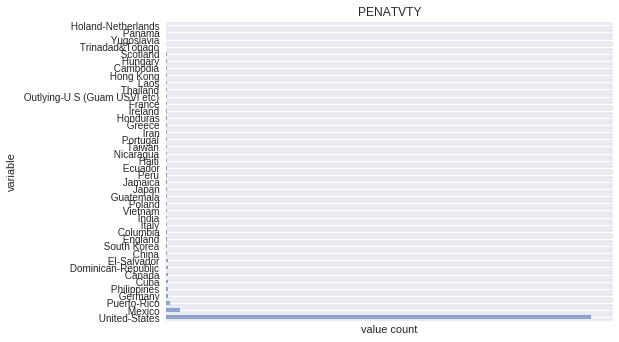

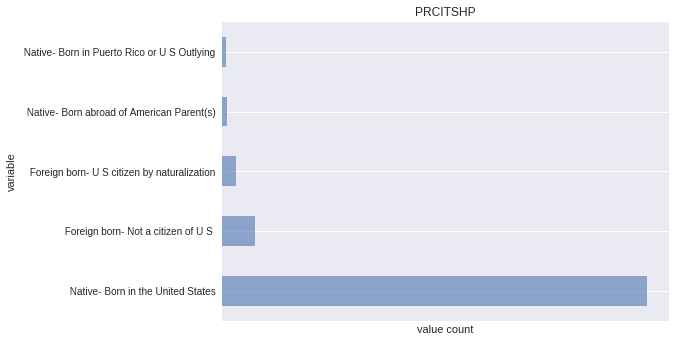

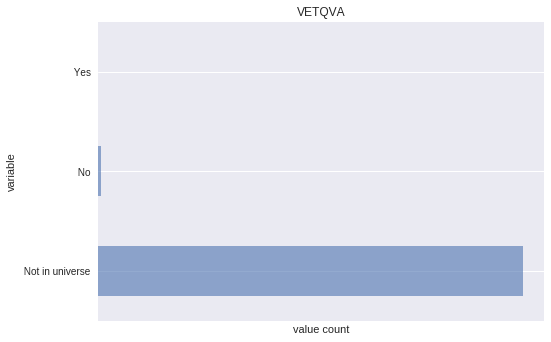

In [0]:
# subset of the dataframe
list_categorical = ['ACLSWKR','AHGA', 'AHSCOL','AMARITL','AMJIND','AMJOCC','ARACE','AREORGN','ASEX','AUNMEM','AUNTYPE','AWKSTAT','FILESTAT',	'GRINREG',	'GRINST','HHDFMX'	,'HHDREL',	'MIGMTR1',	'MIGMTR3',	'MIGMTR4',	'MIGSUN' ,'PARENT','PEFNTVTY', 'PEMNTVTY','PENATVTY','PRCITSHP','VETQVA']	
n = len(features_training_df)

plt.style.use(u'seaborn')

for column in list_categorical:
  features_training_df[column].value_counts().plot(kind='barh', alpha=0.6)
  percentages = (features_training_df[column].value_counts()/n)*100
  
  plt.title(column)
  plt.xlabel('value count')
  plt.xticks([], )
  plt.ylabel('variable')
  plt.show()

The visual representation allows us to select several features to drop because they are not representative of the dataset.

>**CONCLUSION:**
I will be dropping the following list of features for the classification problem:
- GRINST
- VETQVA
- MIGSUN
- MIGMTR4
- MIGMTR3
- MIGMTR1
- GRINREG
- HHFMX / HHDREL?
>>I've decided to drop HHDFMX, which seems to be more detailed than HHDREL, but I don't think it's useful.

We will have to run tests to check if the **PENATVTY, PEMNTVTY  & PEFNTVTY** features are useful or not.

*edit: dropping the 3 columns didn't change the models' score.*

## Last modifications on the datasets (encoding categorical data)
I decided to encode the categorical data to only have numerical, which is more appropriate for most classification models. As you saw previously, I also normalized the numerical data because it is sometimes necessary to do so to use some models.

Moreover, I didn't use every column of the dataset (the following code only uses 22 of them, which is already a big amount.). I think that using every column might lead to over fitting or extra training time, which isn't necessary when we see the results (*see further on*) we obtain with this selection.

In [0]:
#1 hot encoding & feature selection 
keep = ['AAGE','ACLSWKR','ADTIND', 'ADTOCC','AHGA',
        'AHRSPAY','AHSCOL','AMARITL','AMJIND','ARACE',
        'AREORGN','ASEX','AWKSTAT','FILESTAT','HHDREL',
        'NOEMP','PARENT','PRCITSHP','SEOTR','WKSWORK', 'AUNTYPE','AUNMEM']

dummies = ['ACLSWKR','AHGA','AHSCOL','AMARITL',
           'AMJIND','ARACE','AREORGN','ASEX','AWKSTAT',
           'FILESTAT','HHDREL','PARENT','PRCITSHP','AUNTYPE','AUNMEM']


encod_training_features, encod_testing_features = concat_deconcat(features_training_df, features_testing_df, keep, dummies)

In [5]:
# let's check if the dataframe is in the right format.
encod_training_features.head()

,AAGE,ADTIND,ADTOCC,AHRSPAY,NOEMP,SEOTR,WKSWORK,ACLSWKR_ Federal government,ACLSWKR_ Local government,ACLSWKR_ Never worked,ACLSWKR_ Not in universe,ACLSWKR_ Private,ACLSWKR_ Self-employed-incorporated,ACLSWKR_ Self-employed-not incorporated,ACLSWKR_ State government,ACLSWKR_ Without pay,AHGA_ 10th grade,AHGA_ 11th grade,AHGA_ 12th grade no diploma,AHGA_ 1st 2nd 3rd or 4th grade,AHGA_ 5th or 6th grade,AHGA_ 7th and 8th grade,AHGA_ 9th grade,AHGA_ Associates degree-academic program,AHGA_ Associates degree-occup /vocational,AHGA_ Bachelors degree(BA AB BS),AHGA_ Children,AHGA_ Doctorate degree(PhD EdD),AHGA_ High school graduate,AHGA_ Less than 1st grade,AHGA_ Masters degree(MA MS MEng MEd MSW MBA),AHGA_ Prof school degree (MD DDS DVM LLB JD),AHGA_ Some college but no degree,AHSCOL_ College or university,AHSCOL_ High school,AHSCOL_ Not in universe,AMARITL_ Divorced,AMARITL_ Married-A F spouse present,AMARITL_ Married-civilian spouse present,AMARITL_ Married-spouse absent,...,AWKSTAT_ Full-time schedules,AWKSTAT_ Not in labor force,AWKSTAT_ PT for econ reasons usually FT,AWKSTAT_ PT for econ reasons usually PT,AWKSTAT_ PT for non-econ reasons usually FT,AWKSTAT_ Unemployed full-time,AWKSTAT_ Unemployed part- time,FILESTAT_ Head of household,FILESTAT_ Joint both 65+,FILESTAT_ Joint both under 65,FILESTAT_ Joint one under 65 & one 65+,FILESTAT_ Nonfiler,FILESTAT_ Single,HHDREL_ Child 18 or older,HHDREL_ Child under 18 ever married,HHDREL_ Child under 18 never married,HHDREL_ Group Quarters- Secondary individual,HHDREL_ Householder,HHDREL_ Nonrelative of householder,HHDREL_ Other relative of householder,HHDREL_ Spouse of householder,PARENT_ Both parents present,PARENT_ Father only present,PARENT_ Mother only present,PARENT_ Neither parent present,PARENT_ Not in universe,PRCITSHP_ Foreign born- Not a citizen of U S,PRCITSHP_ Foreign born- U S citizen by naturalization,PRCITSHP_ Native- Born abroad of American Parent(s),PRCITSHP_ Native- Born in Puerto Rico or U S Outlying,PRCITSHP_ Native- Born in the United States,AUNTYPE_ Job leaver,AUNTYPE_ Job loser - on layoff,AUNTYPE_ New entrant,AUNTYPE_ Not in universe,AUNTYPE_ Other job loser,AUNTYPE_ Re-entrant,AUNMEM_ No,AUNMEM_ Not in universe,AUNMEM_ Yes
0,0.811111,0.000000,0.00000,0.0,0.000000,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,0.644444,0.078431,0.73913,0.0,0.166667,0.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,0.200000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0.100000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,0.111111,0.000000,0.00000,0.0,0.000000,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


## Classification 

### decision tree

#### training and parameters tuning
To find the best parameters (I focused on `max_depth` which is the most important parameter), I buils models with several values.

Moreover, I've decided to do a cross validation to evaluate a more accurate score, with 5 folds on the dataset.
In that sense, I don't need to split the dataset into training and testing since I am using cross validation.

For the prediction, I decided to run a single prediction based on the full testing dataset

In [0]:
depths = [5,8,10,15,20,50]
for depth in depths:
  clf =  DecisionTreeClassifier(max_depth=depth)
  clf.fit(feat_train, label_train)
  scores = cross_val_score(clf, encod_, label_train, cv=5)
  print(depth, scores.mean())


5 0.9374945071181591
8 0.9436028403736794
10 0.9437970671291284
15 0.9401884451608657
20 0.934167830613809
50 0.9241877530195831


The best `depth` to use is between  `max_depth=8` & `max_depth=10`. We'll use `max_depth=10`.

#### prediction & score

In [0]:
#train the decision tree on the full training dataset
clf =  DecisionTreeClassifier(max_depth=10)
clf.fit(encod_training_features, training_labels_df)

#predict the outcome of the test df
pred = clf.predict(encod_testing_features)

#check the accuracy between prediction & reality
acc = accuracy_score(testing_labels_df,pred)
print("Accuracy : %0.2f" % acc)

Accuracy : 0.95


### ensemble method : random forest
I wanted to try implementing a random forest to see if I could get a higher accuracy or not.

#### parameters tuning

In [0]:
from sklearn.ensemble import RandomForestClassifier as rf

estimators = [10,25,50]
depths = [5,10,20]
for est in estimators:
  for depth in depths:

    rfc= rf(n_estimators = est, max_depth = depth)
    # compute score with a cross-validation
    scores_rfc = cross_val_score(rfc, encod_training_features, training_labels_df, cv=10)
    print(est, depth, scores_rfc.mean())



10 5 0.9381524936648435
10 10 0.9417360297501052
10 20 0.9482615875957257
25 5 0.9379419919690182
25 10 0.9422572792453604
25 20 0.9492188685311043
50 5 0.9379419919690182
50 10 0.94239259950338
50 20 0.9494744747188772


It seems like the best combination is for `n_estimators = 25` & `max_depth=20`.
The results don't change a lot from a single decision tree but I will still check how the models fairs with the prediction.


#### prediction & score

In [0]:
from sklearn.ensemble import RandomForestClassifier as rf

#train the RF on the full training dataset
rfc =  rf(n_estimators = 25, max_depth=20)
rfc.fit(encod_training_features, training_labels_df)

#predict the outcome of the test df
pred = rfc.predict(encod_testing_features)

#check the accuracy between prediction & reality
acc = accuracy_score(testing_labels_df, pred)
print("Accuracy : %0.2f" % acc)

Accuracy : 0.95


As I expected we get slightly better results with a Random Forest.
Now that we've implemented a decision tree and a random forest, I could try implementing other models such as a Multi Layer Perceptron or another ensemble model (bagging or boosting most probably). It might be slightly overboard for a problem as simple as this one but it might help improve the score.

**The best results were with the Random forest model.**


# Difficulties encountered

When I first started working on this problem, I thought that I would do everything in Python. That was probably a mistake and I should have done the data vizualisation part in R, which is much more efficient for this matter. 
(eg : annotating on the plots the % for each value, etc...)

I think the hardest part for me was to show correlation between features and understand which ones had a great impact on the classification, I think I lack some methods in this area.